In [4]:
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pickle
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.externals import joblib
%matplotlib inline

In [6]:
#from lecture notes
def spatial_binning(img,size=(32,32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

In [7]:
# from lecture notes
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


In [8]:
#from lecture_notes
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [9]:
#from lecture notes
def extract_features(image,cspace='BGR',spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # apply color conversion if other than 'RGB'
    if cspace != 'BGR':
        if cspace == 'HSV':
             feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif cspace == 'LUV':
             feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
        elif cspace == 'HLS':
              feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    else: feature_image = np.copy(image)      
    # Apply bin_spatial() to get spatial color features
    spatial_features = spatial_binning(feature_image, size=spatial_size)
    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    # Append the new feature vector to the features list
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    return np.concatenate([spatial_features,hist_features,hog_features])

In [10]:
def extract_features_all_files(imgs, cspace='BGR', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    
        
    return [extract_features(cv2.resize(cv2.imread(file),(64,64)),cspace=cspace,spatial_size=spatial_size,hist_bins=hist_bins,hist_range=hist_range) for file in imgs]

In [11]:
#set hyper parameters
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
hist_bins=32
spatial_size=(16,16)

In [12]:
#reading images
vehicle_path = '/home/carnd/Vehicle-data/vehicles'
vehicle_image_paths = glob.glob(vehicle_path+'/*/*.png',recursive=True)
vehicle_features = extract_features_all_files( [path for path in vehicle_image_paths],cspace=colorspace,spatial_size=spatial_size,hist_bins=hist_bins)



non_vehicle_path = '/home/carnd/Vehicle-data/non-vehicles'
non_vehicle_image_paths = glob.glob(non_vehicle_path+'/*/*.png',recursive=True)
non_vehicle_features =  extract_features_all_files( [path for path in non_vehicle_image_paths],cspace=colorspace,spatial_size=spatial_size,hist_bins=hist_bins)


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [13]:
udacity_vehicle_path = '/home/carnd/Vehicle-data/cropped_images'
udacity_vehicle_image_paths = glob.glob(udacity_vehicle_path+'/*.jpg')
udacity_features = extract_features_all_files( [path for path in udacity_vehicle_image_paths],cspace=colorspace,spatial_size=spatial_size,hist_bins=hist_bins)

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [14]:
vehicle_features=np.array(vehicle_features)
non_vehicle_features=np.array(non_vehicle_features)
udacity_features = np.array(udacity_features)

In [15]:
udacity_features.shape

(12793, 6156)

In [15]:
from sklearn.externals import joblib
joblib.dump(vehicle_features,'/home/carnd/Vehicle-data/vehicles.pkl')
joblib.dump(non_vehicle_features,'/home/carnd/Vehicle-data/non-vehicles.pkl')
joblib.dump(udacity_features,'/home/carnd/Vehicle-data/udacity.pkl')

['/home/carnd/Vehicle-data/udacity.pkl']

['/mnt/features/udacity.pkl']

In [13]:
test_image=cv2.imread(udacity_vehicle_image_paths[0])

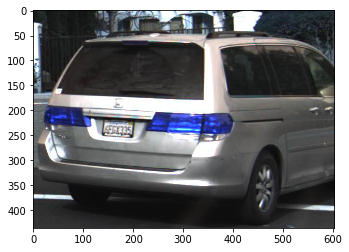

In [14]:
plt.imshow(test_image)

In [47]:
t=extract_features(test_image,cspace='YCrCb',spatial_size=spatial_size,hist_bins=hist_bins)

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [70]:
spatial_binning(test_image).shape

(3072,)

In [16]:
X = np.vstack((vehicle_features,udacity_features,non_vehicle_features))
scaler =  StandardScaler().fit(X)
X_scaled = scaler.transform(X)
y=np.hstack(( np.ones(len(vehicle_features)+len(udacity_features)), 
             np.zeros( (len(non_vehicle_features) ) )))
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.2)


In [17]:
svc = LinearSVC()
X_train_shuffled,y_train_shuffled=shuffle(X_train,y_train)
svc.fit(X_train_shuffled, y_train_shuffled)
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.9807


In [18]:
joblib.dump(svc,'/home/carnd/Vehicle-data/svc.pkl')

['/home/carnd/Vehicle-data/svc.pkl']

#Training done.

In [19]:
#some utility function from lecture notes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def convert_color(img, conv='BGR2YCrCb'):
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'BGR2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [20]:
#efficient window search from lecture notes
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='BGR2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = spatial_binning(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

In [21]:
ystart = 400
ystop = 656
scale = 2  
#out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#plt.imshow(out_img)